![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png)  ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# PEC M5 Análisis de datos estructurados con Spark (4 Dic 2024 - 31 Dic 2024)

## Extracción de conocimiento de fuentes de datos heterogéneas mediante Spark SQL, RDDs

En esta PEC introduciremos estructuras de datos más complejas que las vistas hasta ahora, donde los campos pueden tener otros campos anidados. Utilizaremos los datos de IMDB (https://www.imdb.com/) sobre películas. Específicamente utilizaremos unos archivos sobre 'reviews' de películas realizados por un conjunto de usuarios y sobre estos archivos realizaremos una serie de operaciones mediante SparkSQL y Dataframes.

Realizaremos un conjunto de preguntas sobre los archivos que puede ir respondiendo de forma secuencial.<br>
A lo largo del ejercicio veréis espacios con:
````
<FILL_IN>
````
Devbéis completar estos espacios con los contenidos que se piden.





## 1. Inicialización del entorno y carga de archivos (2 puntos)

Es necesario cargar el entorno de trabajo inicializando SparkContext.

In [4]:
import findspark
findspark.init()
import pyspark
import random
sc = pyspark.SparkContext(master="local[1]", appName="IMDB:Movie_reviews_analysis")

In [5]:

from pyspark import SparkConf, SparkContext, SQLContext, HiveContext
from pyspark.sql import Row

In [6]:
sqlContext = SQLContext(sc)

### 1.1 Carga de archivos de HDFS

Los archivos se encuentran en HDFS, en la ubicación /aula_B0.485/data.
Aquí encontrará una serie de directorios.

* /aula_B0.485/data/movie_details-p4.json, datos con 4 particiones
* /aula_B0.485/data/movie_details.json, datos particionados por movie_id
* /aula_B0.485/data/reviews-p4.json, datos con 4 particiones
* /aula_B0.485/data/reviews.json, datos particionados por rating

Mediante los pedidos trabajados en la primera PAC, explore que tiene en cada directorio.
(NOTA: puede añadir tantas celdas como necesite)


In [4]:
!hdfs dfs -ls /aula_B0.485/data/

Found 10 items
-rw-r--r--   2 asolerib supergroup     318264 2019-11-05 11:19 /aula_B0.485/data/Folds5x2_pp.csv
-rw-r--r--   2 asolerib supergroup  203431368 2019-10-28 11:05 /aula_B0.485/data/LoremIpsum.txt
-rw-r--r--   2 cesc     supergroup    4047392 2024-12-04 16:49 /aula_B0.485/data/bible.txt
drwxr-xr-x   - cesc     supergroup          0 2024-12-04 16:50 /aula_B0.485/data/movie_details-p4.json
drwxr-xr-x   - cesc     supergroup          0 2024-12-04 16:51 /aula_B0.485/data/movie_details.json
drwxr-xr-x   - asolerib supergroup          0 2019-10-28 11:05 /aula_B0.485/data/pec2
drwxr-xr-x   - asolerib supergroup          0 2020-12-10 22:28 /aula_B0.485/data/pec3
drwxr-xr-x   - cesc     supergroup          0 2024-12-04 16:52 /aula_B0.485/data/reviews-p4.json
drwxr-xr-x   - cesc     supergroup          0 2024-12-04 16:52 /aula_B0.485/data/reviews.json
drwxr-xr-x   - asolerib supergroup          0 2019-12-08 16:07 /aula_B0.485/data/tweets28a_sample.json


Mediante el comando hdfs fsck verifica el número de block de cada directorio para entender que existe en cada directorio. Recuerde que son 4 directorios.

In [7]:
!hdfs fsck /aula_B0.485/data/movie_details-p4.json -files -blocks -locations

Connecting to namenode via http://eimtcld2.uoclabs.uoc.es:9870/fsck?ugi=sjuanmon&files=1&blocks=1&locations=1&path=%2Faula_B0.485%2Fdata%2Fmovie_details-p4.json
FSCK started by sjuanmon (auth:SIMPLE) from /213.73.35.120 for path /aula_B0.485/data/movie_details-p4.json at Thu Dec 19 19:32:02 CET 2024
/aula_B0.485/data/movie_details-p4.json <dir>
/aula_B0.485/data/movie_details-p4.json/_SUCCESS 0 bytes, replicated: replication=2, 0 block(s):  OK

/aula_B0.485/data/movie_details-p4.json/part-00000-56a27bb0-9e7f-48c0-b648-4ffa919558ec-c000.json 3598049 bytes, replicated: replication=2, 1 block(s):  OK
0. BP-2074018746-213.73.35.119-1563889676427:blk_1114227937_40504124 len=3598049 Live_repl=2  [DatanodeInfoWithStorage[10.20.30.3:9866,DS-3cb210d3-07c1-4478-b12c-99b56aa0d282,DISK], DatanodeInfoWithStorage[213.73.35.120:9866,DS-c1a5158b-284b-4996-884f-19ef65d8955d,DISK]]

/aula_B0.485/data/movie_details-p4.json/part-00001-56a27bb0-9e7f-48c0-b648-4ffa919558ec-c000.json 3448420 bytes, replicate

In [ ]:
!hdfs fsck /aula_B0.485/data/movie_details.json -files -blocks -locations

In [9]:
!hdfs fsck /aula_B0.485/data/reviews-p4.json -files -blocks -locations

Connecting to namenode via http://eimtcld2.uoclabs.uoc.es:9870/fsck?ugi=sjuanmon&files=1&blocks=1&locations=1&path=%2Faula_B0.485%2Fdata%2Freviews-p4.json
FSCK started by sjuanmon (auth:SIMPLE) from /213.73.35.120 for path /aula_B0.485/data/reviews-p4.json at Thu Dec 19 12:47:46 CET 2024
/aula_B0.485/data/reviews-p4.json <dir>
/aula_B0.485/data/reviews-p4.json/_SUCCESS 0 bytes, replicated: replication=2, 0 block(s):  OK

/aula_B0.485/data/reviews-p4.json/part-00000-b572700e-3c18-474b-aa74-9405b7a55060-c000.json 236266182 bytes, replicated: replication=2, 2 block(s):  OK
0. BP-2074018746-213.73.35.119-1563889676427:blk_1114229512_40505699 len=134217728 Live_repl=2  [DatanodeInfoWithStorage[10.20.30.2:9866,DS-a5c9992a-3697-4504-a963-c2577fd6c171,DISK], DatanodeInfoWithStorage[213.73.35.120:9866,DS-c1a5158b-284b-4996-884f-19ef65d8955d,DISK]]
1. BP-2074018746-213.73.35.119-1563889676427:blk_1114229513_40505700 len=102048454 Live_repl=2  [DatanodeInfoWithStorage[10.20.30.2:9866,DS-a5c9992a-

In [ ]:
!hdfs fsck /aula_B0.485/data/reviews.json -files -blocks -locations

En los directorios /aula_B0.485/data/movie_details-p4.json y /aula_B0.485/data/movie_details.json existen los mismos datos, así como en los directorios /aula_B0.485/data/reviews-p4.json y /aula_B0.485/fecha/reviews.json.

¿Qué se observa en el particionamiento por ratings en HDFS? ¿Qué utilidad puede tener?
Viendo la estructura de particionado del dataframe por ratings, ¿creéis que tendría sentido particionar por movie_id el dataframe movie_details?
Elaborad una respuesta a partir de lo observado, añadiendo capturas de pantalla listando los contenidos en cada caso (si en algún caso la lista es muy larga coja sólo una muestra).

In [12]:
# En el particionamiento  por ratings de HDFS vemos que los datos están distribuidos en particiones en función de la calificación que tengan, por ejemplo: 
# /aula_B0.485/data/reviews.json/rating=6/part-00000). Cada una de estas particiones guardan los registros que tienen un valor concreto de rating, lo que facilita las consultas.
#Por otro lado, en los resultados de hdfs fsck observamos que los archivos están divididos por valor de rating y dentro de cada partición exiten varios archivos (part-00000/part 00001).

#Este tipo de particionamiento por rating tiene mucha utilidad. En primer lugar, las consultas se podrán realizar a través del rating, accediendo al directectorio pertinente,
#en vez de tener que consultar a todo el dataset. Por otro lado, también reduce los datos que hay que leer durante el procesamiento lo que tiene un impacto en el rendimiento.

#Para saber si tendría sentido particionar por movie_id en vez de por movie_details tendríamos que tener claro que clase de consultas queremos realizarle al dataset, por lo que
#puede tener ventajas e inconvenientes particionar por movie_id.

# Ventajas -- Si las consultas que queremos realizar son por películas (buscando detalles de una película en específico a partir de su ID) entonces las consultas serán más rápidas
#puesto que HDFS leería solo la partición relevante. Además, si el volumen de películas es grande y las reseñas de las peliculas son equitativas, entonces tendríamos una distribución
#de datos balanceada que aumentaría la paralelización y eficiencia del procesamiento (se distribuyen de mejor manera los datos entre los nodos del clúster). 

# Desventajas -- En caso contrario, si algunas peliculas tienen pocas reseñas, mientras que otras tienen muchas, algunas particiones pueden albergar muchos más datos que otras,  
#creando un desbalance en los procesamientos. Además, si no tenemos muchos registros de cada movie_id, se podrían dar particiones muy pequeñas que no sean eficientes para el 
#almacenamiento y el procesamiento.

### 1.2 Carga de los archivos en Spark y exploración

Una vez que los archivos ya están en HDFS, se realizará la carga en Spark para su exploración. Seleccionad, para cada caso (movie_details y reviews) el directorio que más le convenga.

(NOTA: se pueden añadir tantas celdas como sea necesario).

In [5]:
movie_details = sqlContext.read.json("/aula_B0.485/data/movie_details.json")

In [6]:
reviews_details = sqlContext.read.json("/aula_B0.485/data/reviews.json")

Utilizad el comando que Spark nos ofrece (_getNumPartitions()_) para conocer el número de particiones de cada uno de los archivos.

In [27]:
movie_details.rdd.getNumPartitions()

50

In [28]:
reviews_details.rdd.getNumPartitions()

10

¿Cuántas particiones hay por cada archivo?

In [ ]:
# Dentro de movie_details tenemos 50 particiones y dentro de reviews_details tenemos 10 particiones.

Una vez cargados los archivos, vamos a explorarlos:

¿Qué tipo de objeto son movie_details y movie_reviwes?

In [30]:
print(type(movie_details))
print(type(reviews_details))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


Convertid el dataframe movie_details a un rdd y seleccionad el primer registro explicando cuál es el resultado:

In [31]:
movie_details_rdd = movie_details.rdd

Una vez hecho un primer análisis de lo que hemos cargado, vamos a ver su contenido. Mediante el comando _show()_, exploramos los primeros 10 registros del dataframe.

<FILL_IN>

In [32]:
movie_details.show(10)

+--------+--------------------+--------------------+--------------------+------+------------+---------+
|duration|               genre|        plot_summary|       plot_synopsis|rating|release_date| movie_id|
+--------+--------------------+--------------------+--------------------+------+------------+---------+
|1h 42min|      [Crime, Drama]|Patrick Bateman i...|A white backgroun...|   7.6|  2000-04-14|tt0144084|
|1h 36min|    [Drama, Fantasy]|A Knight and his ...|The night had bro...|   8.2|  1958-10-13|tt0050976|
|2h 44min|  [Action, Thriller]|Despite his tarni...|Commissioner Jame...|   8.4|  2012-07-20|tt1345836|
|2h 16min|[Action, Adventur...|Lincoln Six Echo ...|The Island begins...|   6.9|  2005-07-22|tt0399201|
|2h 17min|[Action, Sci-Fi, ...|Over 10 years hav...|Scenes described ...|   8.5|  1991-07-03|tt0103064|
|1h 28min|[Action, Adventur...|Kay and Jay reuni...|The Columbia torc...|   6.1|  2002-07-03|tt0120912|
|2h 18min|[Action, Crime, S...|Sean Archer, a ve...|September 19

Como puede verse, el comando _show()_ nos trunca el contenido en aquellas variables textuales demasiado largas. Ahora utilizad el mismo comando para mostrar los 10 primeros registros pero sin truncar su contenido

In [33]:
movie_details.show(10, truncate=False)

+--------+----------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Comentad, ¿Os ha sido útil este comando?

In [ ]:
# Sí, de esta manera puedes observar los datos de las líneas pero de manera extensiva. 

Mostrad cuál es el esquema de cada uno de los dataframes:

In [21]:
reviews_details.printSchema()

root
 |-- is_spoiler: boolean (nullable = true)
 |-- movie_id: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_summary: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- rating: integer (nullable = true)



In [25]:
movie_details.printSchema()

root
 |-- duration: string (nullable = true)
 |-- genre: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- plot_summary: string (nullable = true)
 |-- plot_synopsis: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- movie_id: string (nullable = true)



Analizamos los resultados:

* ¿Qué se observa en el particionamiento por ratings en HDFS? ¿Qué utilidad puede tener?
* Viendo la estructura de particionado del dataframe por ratings, ¿creéis que tendría sentido particionar por movie_id el dataframe movie_details?


In [ ]:
#<El particionamiento por rating en reviews.json es lógico debido a que el campo rating tiene una distribuición bien definida  y esta totalmente relacionado con consultas que
#apelan a las reseñas. En el caso de particionar movie_details por movie_id no sería óptimo, ya que el campo movie_id tiene una alta cardinalidad y particionarlo puede provocar
#la generación de particiones pequeñas, siendo negativo para el rendimiento. Quizás habría que considerar otro campo que no tenga una cardinalidad tan alta (género o fecha de estreno).

## 2. Análisis de los datos
Seguidamente realizaremos un primer análisis más detallado de los archivos.
Volved a cargar los archivos de la ubicación utilizada en 1.3, la que os parezca más eficiente  (4 particiones o particionamiento por campos).

In [7]:
movie_details = sqlContext.read.json("/aula_B0.485/data/movie_details.json")

In [8]:
movie_reviews = sqlContext.read.json("/aula_B0.485/data/reviews.json")

In [37]:
movie_details.printSchema()

root
 |-- duration: string (nullable = true)
 |-- genre: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- plot_summary: string (nullable = true)
 |-- plot_synopsis: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- movie_id: string (nullable = true)



### 2.1 Consultas mediante sql
Spark nos permite realizar consultas sql sobre dataframes que, previamente, hemos tenido que guardar como tablas. Así pues, registraremos el dataframe de movie_details como tabla y realizamos algunas consultas básicas. <br>


Regsitrad el dataframe como tabla temporal:

In [10]:
#Utiulitzeu un nom de taula que desitjeu.
movie_details.registerTempTable("movies_table")

Muchas veces los datos con los que queremos trabajar se utilizarán en varios proyectos. Una forma de organizar los datos es, en el lugar de utilizar directamente las fichas, hacer uso de una base de datos para gestionar la información, esto es, los metadatos de los dataframes. De modo que ya tenemos la estructura almacenada. En el entorno Hadoop, una de las bases de datos más extendidas es Apache Hive, una base de datos que permite trabajar con contenido distribuido.

La forma de acceder a esta base de datos se realiza creando un contexto Hive de forma muy similar a como declaramos un contexto SQL. Ante todo declaramos una variable hiveContext instanciando como un objeto de la clase HiveContext. Seguidamente se comprueba cuántas tablas están registradas en este contexto. Como vemos, la tabla que acabamos de almacenar queda registrada de forma temporal, mente que tenemos otras tablas registradas de forma no temporal.

In [11]:
hiveContext = HiveContext(sc)
hiveContext.tables().show()

+--------+-----------------+-----------+
|database|        tableName|isTemporary|
+--------+-----------------+-----------+
| default|               as|      false|
| default|        mistweets|      false|
| default|     province_28a|      false|
| default|province_28a_vext|      false|
| default|              src|      false|
| default|        tweets28a|      false|
| default|   tweets28a_vext|      false|
| default|        user_info|      false|
| default|   user_info_vext|      false|
|        |     movies_table|       true|
+--------+-----------------+-----------+



A modo de ejemplo, se pide que completéis la siguiente consulta para que nos muestre las películas con un rating superior a 8 y ordenadas en orden descendente:

In [14]:
details_rating_high8 = hiveContext.sql("""  SELECT movie_id, rating, genre
                                    FROM movies_table
                                    where rating > 8
                                    order by rating DESC""")

¿Cuantas hay?

In [15]:
details_rating_high8.count()

8

Seguidamente, realizaremos una consulta más complicada.<br>
Complete la siguiente celda para que la consulta agrupe el número de películas por rating. Es decir, ¿cuántas películas tienen el mismo rating? Esto nos permitirá tener una distribución del número de películas por valoración.

In [12]:
details_rating_grouped = hiveContext.sql("""  SELECT rating, count(*) as count
                                    FROM movies_table
                                    group by rating
                                    order by rating asc""")

In [13]:
details_rating_grouped.show()

+------+-----+
|rating|count|
+------+-----+
|   2.4|    1|
|   2.8|    1|
|   3.3|    1|
|   3.6|    1|
|   3.7|    1|
|   3.8|    2|
|   4.0|    1|
|   4.1|    1|
|   4.2|    2|
|   4.3|    4|
|   4.4|    4|
|   4.5|    1|
|   4.6|    2|
|   4.7|    5|
|   4.8|    3|
|   4.9|    4|
|   5.0|    3|
|   5.1|    9|
|   5.2|    9|
|   5.3|   15|
+------+-----+
only showing top 20 rows



¿Cuál es la nota que más aparece?

In [14]:
# Desde esta línea de código details_rating_grouped.show() observamos que la nota más recurrente es 5.3 con 15 conteos. Sin embargo, estamos viendo solo las 20 primeras líneas,
# por lo que cabría ver los demás ratings para asegurarnos que 5.3 es el rating con más películas. Así pues, como podemos observar en la gráfica generada con Pandas en el siguiente
# ejercicio vemos que el rating mas recurrente es 8.1 con un conteo de más de 70 películas.

Y para completar esta parte del ejercicio, completad la siguiente celda que debe permitirnos representar visualmente la distribución de ratings en la muestra de películas de la que disponemos.

NameError: name 'plt' is not defined

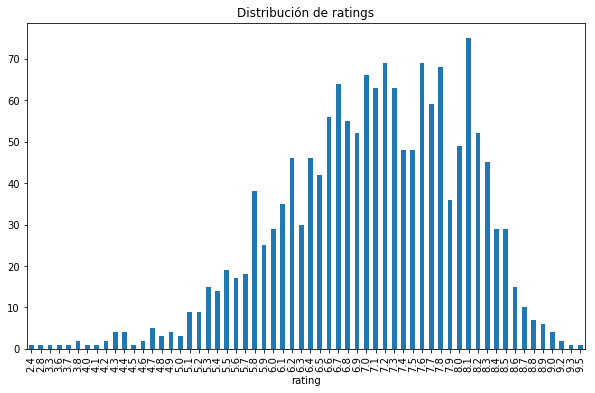

In [18]:
rating_count_pd = details_rating_grouped.toPandas()
rating_count_pd.plot.bar(x="rating", y="count", legend=False, figsize=(10,6), title="Distribución de ratings")
plt.show()

#### 2.2 Analizando el dataset con Spark SQL (6 punts)


Spark SQL ofrece otro mecanismo para aplicar las transformaciones y obtener resultados similares a los que se obtendría aplicando una consulta SQL como se ha practicado en el ejercicio anterior, mediante la API SparkSQL. Podéis consultar [API de spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html) donde se puede encontrar más información sobre cómo utilizar las diferentes transformaciones sobre tablas.


Por ejemplo, la siguiente consulta nos permite obtener todas las películas que tienen una nota superior a 8 tal y como se ha hecho en el ejercicio anterior sin usar una consulta sql literal:
````
movie_details.where("rating>=8").select("movie_id, rating")
````

A continuación uno planteamos unos ejercicios para que utilice la API SparkSQL, una de las más utilizadas actualmente en el mundo de la ingeniería de datos.
Los ejercicios que se plantean son muy típicos de un proyecto de definición de indicadores, por ejemplo. En este caso, son una serie de indicadores relativos a la actividad de los usuarios y su valoración de las películas.

Podéis utilizar las transformaciones "where", "select" (o "selectExpr"), "groupBy", "count", "agg" y "orderBy".

##### 2.2.1 ¿Cuál es el usuario que ha escrito más reviews? ¿Y lo que ha escrito menos (en caso de que haya más de uno indica cuántos hay)?

A continuación se pide que encontréis el usuario que ha escrito más reviews:

In [16]:
movie_reviews.groupBy("user_id").agg({"movie_id":"count"}).orderBy("count(movie_id)", ascending=False).show(10)

+----------+---------------+
|   user_id|count(movie_id)|
+----------+---------------+
| ur2898520|           1303|
| ur4248714|           1021|
| ur0453068|            806|
|ur60028700|            770|
|ur20552756|            755|
| ur4888011|            701|
| ur2488512|            681|
| ur1234929|            680|
| ur1293485|            660|
| ur0482513|            641|
+----------+---------------+
only showing top 10 rows



In [17]:
review_counter_user=movie_reviews.groupBy("user_id").agg({"movie_id": "count"}).orderBy("count(movie_id)", ascending=True)

In [18]:
review_counter_user.show()

+----------+---------------+
|   user_id|count(movie_id)|
+----------+---------------+
| ur1153990|              1|
| ur1430482|              1|
| ur1103899|              1|
|ur48823143|              1|
|ur21059122|              1|
|ur39026579|              1|
|ur73297517|              1|
|ur47125783|              1|
| ur2916055|              1|
|ur81573403|              1|
|ur27508189|              1|
|ur69130034|              1|
|ur47738038|              1|
|ur80541192|              1|
|ur56009258|              1|
|ur44809077|              1|
|ur65947123|              1|
|ur66404918|              1|
| ur3181746|              1|
|ur51028935|              1|
+----------+---------------+
only showing top 20 rows



Como se puede ver, hay bastantes que comparten el número mínimo de valoraciones. Ahora se pide que calcule cuántos usuarios comparten la mínima:

In [19]:
review_count=movie_reviews.groupBy("user_id").agg({"movie_id": "count"}).orderBy("count(movie_id)", ascending=True).withColumnRenamed("count(movie_id)", "review_count")

In [20]:
review_count.where("review_count == " + str(review_count.agg({"review_count": "min"}).collect()[0][0])).count()

202194

Observad cómo en este ejercicio hemos introducido una funcionalidad que es de mucha utilidad al transformar datos:
````
.withColumnRenamed("count(movie_id)", "review_count")
````
Esto nos permite cambiar columnas de nombre y suele ser muy útil cuando se trabaja con agregaciones, ya que por defecto Spark añade el nombre de la función de agregación y la columna.

##### 2.2.2 ¿Cuál es el usuario que ha escrito más reviews con spoiler?

De forma similar a la anterior, ahora querremos saber cuál es el usuario que ha escrito más reviews que contenían contenido etiquetado como 'spoiler'.

In [44]:
#Volem filtrar per aqueslls que el camp spoiler es True.
movie_reviews.where("is_spoiler == True").groupBy("user_id").agg({"movie_id": "count"}).orderBy("count(movie_id)", ascending=False).show(10)

+----------+---------------+
|   user_id|count(movie_id)|
+----------+---------------+
| ur4248714|           1019|
|ur60028700|            767|
| ur5291991|            540|
| ur7813355|            503|
|ur22668817|            473|
| ur2079400|            454|
| ur2707735|            441|
|ur45215448|            422|
|ur13977076|            417|
| ur1697212|            415|
+----------+---------------+
only showing top 10 rows



##### 2.2.3 ¿Existe alguna inconsistencia entre los ratings del archivo de detalles y el archivo de reviews?

Éste es un ejercicio más complejo y muy relacionado con la calidad de los datos. Entendemos por inconsistencia que el promedio de 'ratings' de las películas del dataset 'movie details' no se corresponda con el promedio de notas del archivo 'reviews'. Así, se pide que calculéis este promedio y lo comparéis con el que se obtiene del archivo details. Cread una nueva columna en el dataset que muestre la diferencia en valor absoluto y ordenad por esta columna en orden descendente. Esto nos permitirá ver qué películas tienen mayores inconsistencias entre ambos valores.

Inicialmente seleccionaremos el movieID y su valoración del archivo movie_details. Hay que tener en cuenta que el tipo de rating es string, por lo que es necesario convertirlo a double.

In [45]:
from pyspark.sql.types import DoubleType
rating_movies_from_details_file=movie_details.select("movie_id","rating").withColumn("ratingD", movie_details["rating"].cast(DoubleType())).select("movie_id","ratingD")

#Hem convertit el tipus rating a double, ja que es un valor string i no ens permetria realitzar operacions aritmètiques.

Aquí hemos introducido una nueva funcionalidad muy útil,
````
.withColumn("ratingD", movie_details["rating"].cast(DoubleType()))
````
Es una utilidad clave ya que habitualmente cuando se manipulan datasets hace falta ir añadiendo columnas y, en muchas ocasiones, son columnas intermedias que no formarán parte del dataset final, pero que contienen operaciones que nos permiten calcular nuevas columnas con nuevos valores.

Ahora queremos calcular la media de valoraciones del otro archivo, el de reviews, que compararemos después con el que tenemos del dataframe rating_movies_from_details_file. De forma similar al caso anterior, debemos convertir el tipo de rating a Double, ya que es un string y tampoco nos permite realizar operaciones aritméticas.

In [49]:
rating_reviews=movie_reviews.withColumn("ratingD", movie_reviews["rating"].cast(DoubleType())).select("movie_id","ratingD").groupBy("movie_id").agg({"ratingD":"avg"}).orderBy("avg(ratingD)", ascending=True).withColumnRenamed("avg(ratingD)", "media_rating_review")

Explorad los dos dataframes que hemos creado mediante show().

In [47]:
rating_movies_from_details_file.show(10)

+---------+-------+
| movie_id|ratingD|
+---------+-------+
|tt0144084|    7.6|
|tt0050976|    8.2|
|tt1345836|    8.4|
|tt0399201|    6.9|
|tt0103064|    8.5|
|tt0120912|    6.1|
|tt0119094|    7.3|
|tt0814255|    5.9|
|tt0454848|    7.6|
|tt0119654|    7.3|
+---------+-------+
only showing top 10 rows



In [50]:
rating_reviews.show(10)

+---------+-------------------+
| movie_id|media_rating_review|
+---------+-------------------+
|tt2488496| 2.5926928281461437|
|tt2527336|  2.938775510204082|
|tt0118688| 3.1118210862619806|
|tt0185183| 3.1613394216133943|
|tt0105643| 3.2929577464788733|
|tt1392170| 3.4714285714285715|
|tt0938283| 3.6424657534246574|
|tt1099212|  3.754874651810585|
|tt1502712|           3.796875|
|tt1060277| 3.8971583220568338|
+---------+-------------------+
only showing top 10 rows



Ahora queremos hacer un join entre los dos dataframes, que debe permitirnos comparar los ratings de los dos dataframes. Observa que en la siguiente celda cambiaremos la notación de selección de campos. En lugar de seleccionar los campos con los valores textuales ("movie_id"), podemos seleccionar el campo utilizando el nombre del dataframe y añadiendo el nombre de la columna mediante un punto.

Por ejemplo:
````
rating_reviews.movie_id
````
Podéis trabajar como os sea más fácil y práctico.

In [51]:
joined=rating_movies_from_details_file.join(rating_reviews, rating_movies_from_details_file.movie_id == rating_reviews.movie_id, 'inner') .select(rating_reviews.movie_id, rating_movies_from_details_file.ratingD, rating_reviews.media_rating_review) 

In [52]:
joined.show()

+---------+-------+-------------------+
| movie_id|ratingD|media_rating_review|
+---------+-------+-------------------+
|tt2488496|    8.0| 2.5926928281461437|
|tt2527336|    7.5|  2.938775510204082|
|tt0118688|    3.7| 3.1118210862619806|
|tt0185183|    2.4| 3.1613394216133943|
|tt0105643|    2.8| 3.2929577464788733|
|tt1392170|    7.2| 3.4714285714285715|
|tt0938283|    4.2| 3.6424657534246574|
|tt1099212|    5.2|  3.754874651810585|
|tt1502712|    4.3|           3.796875|
|tt1060277|    7.0| 3.8971583220568338|
|tt1446714|    7.0|  4.025710419485792|
|tt0103923|    3.3|             4.0625|
|tt0388419|    5.3|   4.06282722513089|
|tt0312528|    3.8|  4.077562326869806|
|tt0449010|    5.1|  4.152472527472527|
|tt1389072|    5.8|  4.153846153846154|
|tt0120891|    4.8|  4.167728237791932|
|tt2955096|    5.5|                4.2|
|tt0816692|    8.6|  4.241519674355495|
|tt1606378|    5.3|  4.254620123203286|
+---------+-------+-------------------+
only showing top 20 rows



Por último, calcularemos la diferencia entre los valores que tenemos en el dataframe joined.

In [59]:
from  pyspark.sql.functions import abs
#Hem important la funció abs. En exercicis següents n'importarem altres.

joined_relative_diff=joined.withColumn("Diferencia_relativa",joined.ratingD-joined.media_rating_review)

#A joined relative tenim valors relatius, positius i negatius. Apliquem la funció abs per a crear una columna més que ens permeti obtenir el valor absolut.

joined_absolute_diff=joined_relative_diff.withColumn("Diferencia_absoluta",abs(joined_relative_diff.Diferencia_relativa)).orderBy("Diferencia_absoluta", ascending=False)

Mostrad los resultados:

In [60]:
joined_absolute_diff.show()

+---------+-------+-------------------+-------------------+-------------------+
| movie_id|ratingD|media_rating_review|Diferencia_relativa|Diferencia_absoluta|
+---------+-------+-------------------+-------------------+-------------------+
|tt2488496|    8.0| 2.5926928281461437|  5.407307171853857|  5.407307171853857|
|tt2527336|    7.5|  2.938775510204082|  4.561224489795919|  4.561224489795919|
|tt0816692|    8.6|  4.241519674355495|  4.358480325644504|  4.358480325644504|
|tt1375666|    8.8|  4.832402234636872|  3.967597765363129|  3.967597765363129|
|tt0266697|    8.1|   4.27364185110664|   3.82635814889336|   3.82635814889336|
|tt1392170|    7.2| 3.4714285714285715| 3.7285714285714286| 3.7285714285714286|
|tt0361748|    8.3|  4.701262272089761| 3.5987377279102395| 3.5987377279102395|
|tt0416449|    7.7|  4.287292817679558| 3.4127071823204425| 3.4127071823204425|
|tt2543164|    8.0|   4.59781121751026| 3.4021887824897403| 3.4021887824897403|
|tt1392190|    8.1|  4.703804347826087| 

##### 2.2.4 De las películas de Acción, ¿cuál es la relación entre el número de spoilers respecto al total?

Entendemos como 'relación' el resultado de la división del número de películas con spoiler respecto al total de películas, en este caso, sólo las de género acción. Aclaración: Una película puede pertenecer a más de un género. En este caso, contaremos todas las películas que tengan el género de Acción como uno de los géneros, aunque tengan otros.
A partir de ahora utilizaremos de forma más intensa las funciones de Spark: https://spark.apache.org/docs/latest/api/sql/

El género lo tenemos en el archivo details, mientras que la información relativa a los spoilers la tenemos en el archivo reviews, por lo que habrá que hacer un join de ambos dataframes de nuevo.

In [13]:
from pyspark.sql import functions as F
# las Functions de Spark son un conjunto de utilidades extensa que permite realizar múltiples operaciones sobre los dataframes.
total_action_movies=movie_details.select("movie_id",F.explode("genre").alias("genre")).join(movie_reviews, movie_details.movie_id == movie_reviews.movie_id, "inner").where("genre == 'Action'")

In [14]:
#Ara recupereu el nombre de pelicules d'Acció i els assignem a la variable total_action_movies
total_action_movies_count = total_action_movies.count()

Tomad nota de la función
````
F.explode("género")
````
porque será necesario utilizarla más veces a lo largo del ejercicio.


Necesitamos ahora obtener el número de películas con Spoiler:

In [62]:
total_action_movies_count_spolier=total_action_movies.where("is_spoiler == True").count()

Calcula la relación entre el número de películas con spoiler sobre el total a partir de las dos variables calculadas: total_action_movies_count y total_action_movies_count_spolier


In [ ]:
#<FILL_IN>


##### 2.2.5 ¿Cuál es la media de antigüedad de las películas? ¿Y cuál es la diferencia (en número absoluto) media de la antigüedad de las películas de acción y las de terror (Horror)?

En este ejercicio queremos saber cuál es la antigüedad media de las películas (en años), tomando como referencia el release date respecto a la fecha actual. El resultado que se muestre debe ser en años.

Tal y como nos ha pasado antes con los ratings, es necesario cambiar el formato de release date a date, ya que es un string y Spark no sabe cómo operar con ellos. De modo que haremos uso de una nueva función de Spark:
to_date() sobre el campo release date.

In [30]:
movie_details_dates.printSchema()

root
 |-- duration: string (nullable = true)
 |-- genre: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- plot_summary: string (nullable = true)
 |-- plot_synopsis: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- movie_id: string (nullable = true)
 |-- converted_date: date (nullable = true)



In [27]:
movie_details_dates = movie_details.withColumn('converted_date', F.to_date(movie_details.release_date))

Ejecute la siguiente celda. Veréis que hemos introducido nuevas funciones para manipular campos del dataframe:
````
col: nos permite seleccinar columnas.
current_date() nos devuelve la fecha actual.
datediff() calcula la diferencia entre dos fechas.
````


In [28]:
movies_age=movie_details_dates.select(
      F.col("*"),
      F.current_date().alias("current_date"),
      F.datediff(F.current_date(), F.col("converted_date")).alias("datediff")
    ).agg({"datediff":"avg"})

El comando ejecutado podría haberse construido de formas diferentes, el objetivo es que pueda explorar la potencialidad de SparkSQL, que actualmente es la herramienta primordial de procesado de datos e ingeniería de datos.
Este comando debe devolvernos la media de antigüedad de las películas en días.

Explorad el dataframe resultante:

In [23]:
movies_age.show()

+-----------------+
|    avg(datediff)|
+-----------------+
|8580.677707006369|
+-----------------+



Capturad el dataframe resultante en un array mediante collect(). ¿Cuántos elementos tiene el dataframe?

In [73]:
age=movies_age.collect()

print(len(age))

1


Ahora es necesario tomar el valor numérico del número de días de antigüedad media y dividirlo por 365, que nos devolverá el promedio de años.

In [76]:
years_age=age[0][0]/365

print(years_age)

23.508706046592792



Observad cómo hemos tratado el resultado age[0][0]. ¿Qué tipo de objeto es age y porqué lo hemos tratado así?

In [ ]:
# Age es una lista de filas que hemos obtenido de la función collect, Cada una de estas filas en age alude a un objeto de tipo Row (representación interna de una fila en Spark)
# Lo tratamos de esta manera ya que a partir de age[0] accedemos al primer elemento de la lista (en nuestro caso, solo tenemos un elemento que es un promedio global) y a partir de,
# age[0][0] accedemos al primer valor que hay dentro de la fila en este caso, el promedio de antigüedad global de las películas. 

El ejercicio para determinar la diferencia por géneros es muy similar, pero añadiendo un criterio de agrupación por 'género'. De modo que en la siguiente celda debe realizar la agrupación por género del promedio de antigüedad de las películas.

Sin embargo, introduciremos una nueva notación para realizar agregaciones, mediante las funciones de SparkSQL que ya hemos utilizado. Observe cómo se ```` F.avg('datediff') ```` respecto a la notación de claves anterior.

In [31]:
movies_age=movie_details_dates.select(F.explode(F.col("genre")).alias("genre"), "datediff").groupBy("genre").agg(F.avg('datediff'))

AnalysisException: "cannot resolve '`datediff`' given input columns: [genre, rating, plot_summary, duration, plot_synopsis, genre, movie_id, release_date, converted_date];;\n'Project [genre#216, 'datediff]\n+- Generate explode(genre#7), false, [genre#216]\n   +- Project [duration#6, genre#7, plot_summary#8, plot_synopsis#9, rating#10, release_date#11, movie_id#12, to_date(release_date#11, None) AS converted_date#180]\n      +- Relation[duration#6,genre#7,plot_summary#8,plot_synopsis#9,rating#10,release_date#11,movie_id#12] json\n"

Muestrad los resultados mediante un show().

In [19]:
movies_age.show()

+-----------------+
|    avg(datediff)|
+-----------------+
|8580.677707006369|
+-----------------+




Ahora es necesario seleccionar los géneros para poder comparar ambos valores:

In [ ]:
horror_movie_age=movies_age.where("genre=='<FILL_IN>'").collect()[<FILL_IN>][<FILL_IN>]
action_movie_age=movies_age.where("genre=='<FILL_IN>'").collect()[<FILL_IN>][<FILL_IN>]


In [ ]:
(horror_movie_age-action_movie_age)/365

##### 2.2.6 ¿Cuál es el usuario que pone mejores valoraciones (media aritmética)? ¿Y el que las pone peores? NOTA: Ignoraremos a los usuarios que han escrito menos de 10 reviews y si hay más de uno, muéstralos todos.

En este ejercicio repetimos ya un patrón de desarrollo muy similar al de ejercicios anteriores. Así que es menos guiado que los demás y queda más abierto a que lo completéis mediante la experiencia de los ejercicios anteriores. Podéis crear las celdas que sean necesarias.

In [ ]:
#<FILL_IN>

##### 2.2.7 Mostrad la media de los rating de las películas por género.

De forma similar al ejercicio 2.2.6, aquí se pide que pueda completar el ejercicio sin contenido previo.

In [ ]:
#<FILL_IN>

##### 2.2.8 ¿Cuáles son los 10 años con mayor número de películas 'released'?

NOTA: Usad el release date

In [ ]:
#<FILL_IN>